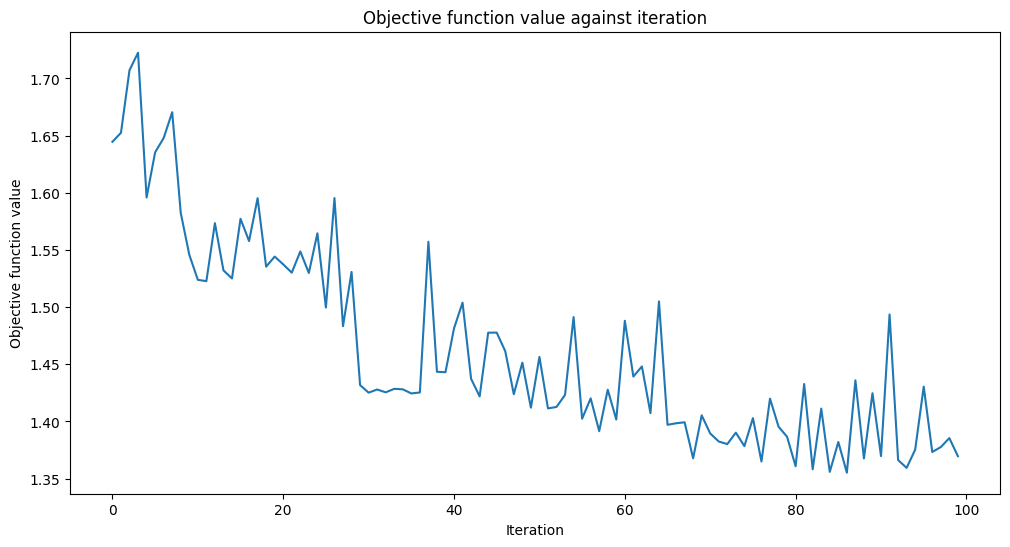

Final Classification Accuracy: 0.63


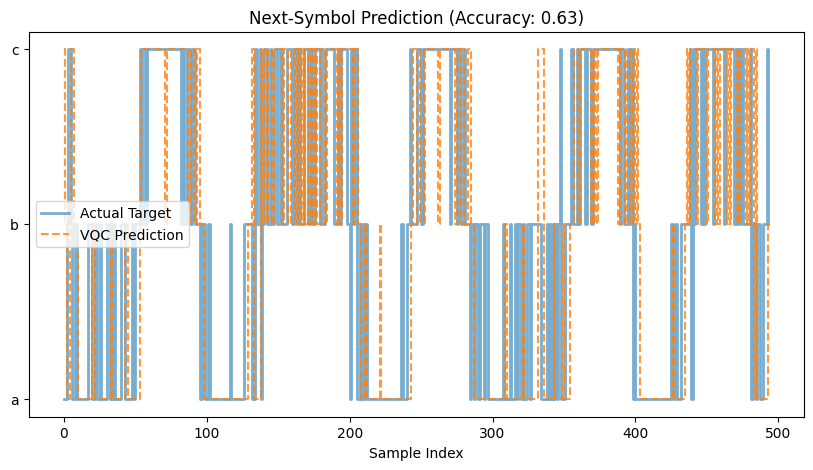

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 1. Imports and Setup
from sklearn.preprocessing import LabelBinarizer
from pyts.approximation import SymbolicAggregateApproximation

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, PauliFeatureMap, EfficientSU2
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.optimizers import COBYLA

from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.utils import algorithm_globals

# Ensure reproducibility
algorithm_globals.random_seed = 12345

# # --- 2. Data Preparation ---
# t = np.linspace(0, 4*np.pi, 500)
# data = np.sin(t) + np.random.normal(0, 0.1, 500)

# sax = SymbolicAggregateApproximation(n_bins=3, strategy='normal')
# data_reshaped = data.reshape(1, -1)
# sax_sequence = sax.fit_transform(data_reshaped)[0] 

# X_sax = []
# y_sax = []
# window_size = 6

# for i in range(len(sax_sequence) - window_size):
#     X_sax.append(sax_sequence[i:i + window_size])
#     y_sax.append(sax_sequence[i + window_size])

# X_sax = np.array(X_sax)
# y_sax = np.array(y_sax)

# # 1. Wider Angle Mapping
# # map a-c to angles between 0 and pi
# map_dict = {'a': 0.2, 'b': 1.57, 'c': 2.9}
# X_angles = np.vectorize(map_dict.get)(X_sax)

# lb = LabelBinarizer()
# y_one_hot = lb.fit_transform(y_sax)

# --- 2. Data Preparation (Updated with Composite Sine Wave) ---
num_samples = 500 # Kept at 500 to maintain data volume for SPSA
eps = 0.2
lb, ub = -np.pi, np.pi

# Your new composite function
f = lambda x: (np.sin(5.0 * x) + 0.5 * np.sin(8.0 * x)) / 4.0 + 0.5

t = np.linspace(lb, ub, num_samples)
# Generating the noisy signal
data = f(t) + eps * (2 * np.random.rand(num_samples) - 1)

# --- SAX Transformation ---
sax = SymbolicAggregateApproximation(n_bins=3, strategy='quantile')
data_reshaped = data.reshape(1, -1)
sax_sequence = sax.fit_transform(data_reshaped)[0] 

X_sax = []
y_sax = []
window_size = 6

for i in range(len(sax_sequence) - window_size):
    X_sax.append(sax_sequence[i:i + window_size])
    y_sax.append(sax_sequence[i + window_size])

X_sax = np.array(X_sax)
y_sax = np.array(y_sax)

# --- Angle Mapping ---
map_dict = {'a': 0.2, 'b': 1.57, 'c': 2.9}
X_angles = np.vectorize(map_dict.get)(X_sax)

# One-hot encoding for the VQC loss function
lb_bin = LabelBinarizer()
lb_bin.fit(['a', 'b', 'c'])    
y_one_hot = lb_bin.transform(y_sax)


# --- 3. Callback & Setup ---
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(*args):
    clear_output(wait=True)
    obj_func_eval = args[1] if len(args) == 2 else args[2]
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


# --- 4. Model Construction ---
num_qubits = X_angles.shape[1]
pauli_map_xy = PauliFeatureMap(num_qubits, reps=1, paulis=['Z', 'Y', 'X'])
effsu2_ansatz = EfficientSU2(num_qubits, reps=2, entanglement="linear", insert_barriers=True)
optimizer = COBYLA(maxiter=100)
sampler = StatevectorSampler() 


# Map the number of '1's in the bitstring to 4 classes
def interpret_3_bins(bitstring):
    count = bin(bitstring).count("1")
    return count % 3

vqc = VQC(
    feature_map=pauli_map_xy,
    ansatz=effsu2_ansatz,
    interpret=interpret_3_bins, 
    output_shape=3,
    loss="cross_entropy",
    optimizer=optimizer,
    callback=callback_graph,
    sampler=sampler
)

print("unique y_sax:", np.unique(y_sax))
print("y_one_hot shape:", y_one_hot.shape)  # must be (N, 3)
assert y_one_hot.shape[1] == 3


# --- 5. Model Training ---
vqc.fit(X_angles, y_one_hot)

vqc.warm_start = True


# --- 6. Results ---
score = vqc.score(X_angles, y_one_hot)
print(f"Final Classification Accuracy: {score:.2f}")

plt.rcParams["figure.figsize"] = (10, 5)
predicted_one_hot = vqc.predict(X_angles)
predicted_labels = np.argmax(predicted_one_hot, axis=1)
actual_labels = np.argmax(y_one_hot, axis=1)

plt.figure()
plt.step(range(len(actual_labels)), actual_labels, label='Actual Target', where='post', alpha=0.6, linewidth=2)
plt.step(range(len(predicted_labels)), predicted_labels, label='VQC Prediction', where='post', linestyle='--', alpha=0.8)
plt.yticks([0, 1, 2], "a b c".split())
plt.xlabel("Sample Index")
plt.title(f"Next-Symbol Prediction (Accuracy: {score:.2f})")
plt.legend()
plt.show()

In [ ]:
# --- 2. Data Preparation (Composite Sine Wave + SAX + Trend channel) ---
num_samples = 500
eps = 0.2
lb, ub = -np.pi, np.pi

f = lambda x: (np.sin(5.0 * x) + 0.5 * np.sin(8.0 * x)) / 4.0 + 0.5

t = np.linspace(lb, ub, num_samples)
data = f(t) + eps * (2 * np.random.rand(num_samples) - 1)

# --- SAX on raw level ---
sax = SymbolicAggregateApproximation(n_bins=3, strategy="quantile")
sax_sequence = sax.fit_transform(data.reshape(1, -1))[0]  # letters 'a','b','c'

window_size = 8

# Sliding-window SAX dataset (level symbols)
X_sax = []
y_sax = []
for i in range(len(sax_sequence) - window_size):
    X_sax.append(sax_sequence[i : i + window_size])
    y_sax.append(sax_sequence[i + window_size])

X_sax = np.array(X_sax)
y_sax = np.array(y_sax)

# --- Trend channel from raw data (first difference) aligned to same windows ---
# d[t] = data[t] - data[t-1], with d[0]=0
d = np.diff(data, prepend=data[0])

X_trend = []
for i in range(len(d) - window_size):
    X_trend.append(d[i : i + window_size])
X_trend = np.array(X_trend)

# --- Map SAX symbols -> angles (level channel) ---
map_dict = {"a": 0.2, "b": 1.57, "c": 2.9}
X_level_angles = np.vectorize(map_dict.get)(X_sax).astype(float)  # (N, window_size)

# --- Map trend values -> angles (trend channel), robust scaling + clipping ---
# scale so typical magnitudes land inside [-pi, pi]
scale = np.pi / (np.percentile(np.abs(X_trend), 95) + 1e-9)
X_trend_angles = np.clip(X_trend * scale, -np.pi, np.pi)          # (N, window_size)

# --- Final input matrix: concatenate [level | trend] ---
# Use a custom feature map with 2*window_size input params (RY for level, RZ for trend)
X_angles = np.hstack([X_level_angles, X_trend_angles])            # (N, 2*window_size)

# --- One-hot targets (force 3 columns always) ---
lb_bin = LabelBinarizer()
lb_bin.fit(["a", "b", "c"])
y_one_hot = lb_bin.transform(y_sax)                               # (N, 3)

print("X_angles shape:", X_angles.shape)  # (N, 12) when window_size=6
print("y_one_hot shape:", y_one_hot.shape)
print("unique y_sax:", np.unique(y_sax))


# --- 3. Callback & Setup ---
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(*args):
    clear_output(wait=True)
    obj_func_eval = args[1] if len(args) == 2 else args[2]
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


# --- 4. Model Construction (UPDATED for level+trend inputs) ---
# X_angles shape is (N, 2*window_size). We need num_qubits = window_size, not 2*window_size.
# The feature map will consume 2*window_size input parameters and apply them onto window_size qubits.
num_qubits = window_size

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def level_trend_with_cz_chain(num_qubits: int, reps: int = 1):
    qc = QuantumCircuit(num_qubits, name="LEVEL_TREND_CZ")
    x = ParameterVector("x", length=2*num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            qc.ry(x[i], i)                 # level
            qc.rz(x[num_qubits + i], i)    # trend
        for i in range(num_qubits - 1):
            qc.cz(i, i+1)

    return qc

feature_map = level_trend_with_cz_chain(window_size, reps=1)


ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement="linear", reps=2)
optimizer = COBYLA(maxiter=100)
sampler = StatevectorSampler()

# Keep interpret, but avoid class-mismatch if a symbol is missing in this run
present = np.unique(y_sax)
num_classes_present = len(present)  # could be 2 or 3

def interpret_mod_classes(bitstring):
    return bin(bitstring).count("1") % num_classes_present

# If you want to FORCE 3 classes regardless, keep interpret_3_bins AND ensure y_sax contains all 3 symbols.
# Otherwise, use data-driven classes:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    interpret=interpret_mod_classes,
    output_shape=num_classes_present,
    loss="cross_entropy",
    optimizer=optimizer,
    callback=callback_graph,
    sampler=sampler,
)

print("unique y_sax:", present)
print("y_one_hot shape:", y_one_hot.shape)
print("num_classes_present:", num_classes_present)

# Use only the columns for present classes (prevents loss expecting 3 when only 2 are present)
class_to_col = {c: i for i, c in enumerate(["a", "b", "c"])}
cols = [class_to_col[c] for c in present]
y_used = y_one_hot[:, cols]

# --- 5. Model Training ---
vqc.fit(X_angles, y_used)
vqc.warm_start = True


# --- 6. Results ---
score = vqc.score(X_angles, y_used)
print(f"Final Classification Accuracy: {score:.2f}")

plt.rcParams["figure.figsize"] = (10, 5)
predicted = vqc.predict(X_angles)              # shape (N, num_classes_present)
pred_labels = np.argmax(predicted, axis=1)
true_labels = np.argmax(y_used, axis=1)

plt.figure()
plt.step(range(len(true_labels)), true_labels, label="Actual Target", where="post", alpha=0.6, linewidth=2)
plt.step(range(len(pred_labels)), pred_labels, label="VQC Prediction", where="post", linestyle="--", alpha=0.8)

# label y-axis with the symbols actually present
plt.yticks(range(num_classes_present), present.tolist())

plt.xlabel("Sample Index")
plt.title(f"Next-Symbol Prediction (Accuracy: {score:.2f})")
plt.legend()
plt.show()




In [ ]:
plt.figure(figsize=(12, 5))
plt.step(range(100), actual_labels[:100], label='Actual', alpha=0.6, linewidth=3)
plt.step(range(100), predicted_labels[:100], label='VQC Prediction', linestyle='--', color='orange')
plt.title("Zoomed-In Prediction (First 100 Samples)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Get predictions
# Ensure we use the full X_angles and y_one_hot for a complete picture
y_pred_probs = vqc.predict(X_angles)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_one_hot, axis=1)

# 2. Print the text report
target_names = ['a (Low)', 'b (Mid)', 'c (High)']
print("Quantum VQC Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 3. Plot the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix: Predicted vs Actual SAX Symbols')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import log_loss

y_probs_clipped = np.clip(y_pred_probs, 1e-15, 1 - 1e-15)
vqc_log_loss = log_loss(y_one_hot, y_probs_clipped)

print(f"Final VQC Log-Loss: {vqc_log_loss:.4f}")

In [ ]:
# Calculate individual log-loss per sample
# Small epsilon to prevent log(0)
eps = 1e-15
y_probs_smooth = np.clip(y_pred_probs, eps, 1 - eps)
individual_losses = -np.sum(y_one_hot * np.log(y_probs_smooth), axis=1)

# Find top 5 hardest samples
top_5_indices = np.argsort(individual_losses)[-5:]

print("Top 5 Hardest Samples (Indices):", top_5_indices)
print("Losses for these samples:", individual_losses[top_5_indices])

In [ ]:
# Create a plot of the original data and mark the failure points
plt.figure(figsize=(12, 5))

# Plot the underlying sine wave for context
plt.plot(t, data, label='Noisy Sine Wave', color='lightgray', alpha=0.7)

# Highlight the 5 samples where the VQC hit the max log-loss penalty
# Note: window_size is subtracted because X_sax starts at index 10
failure_times = t[top_5_indices + window_size]
failure_values = data[top_5_indices + window_size]

plt.scatter(failure_times, failure_values, color='red', s=100, 
            label='Hardest Samples (Max Log-Loss)', zorder=5)

plt.title("Locations of Maximum Prediction Error")
plt.xlabel("Time (t)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()